Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Szuba"

---

# 3. Metody tradycyjne

## 3.1. Podział metod tradycyjnych

Pierwsze zaproponowane metody uczenia reprezentacji dla danych grafowych były często metodami **transduktywnymi**. Oznacza to m.in., że raz wyuczony model nie jest w stanie wyznaczyć reprezentacji dla wcześniej nieobserwowanych wierzchołków (ang. *unseen nodes*). Implikuje to również, że cały graf musi być przetworzony przez model – nie można wyuczyć funkcji osadzania (embedding) na części grafu i następnie wyznaczać reprezentacje dla konkretnych węzłów. Modele transduktywne nie są stosowane na dużych (wielkoskalowych) grafach ze względu na wybuchającą liczbę parametrów tych modeli.

Wśród tradycyjnych metod uczenia reprezentacji dla danych grafowych można wyróżnić metody oparte o:
- błądzenia losowe (ang. *random-walks*) – np. DeepWalk, Node2vec,
- faktoryzację macierzy (ang. *matrix factorization*) – np. HOPE, Graph Factorization, GraRep,
- grafowe macierze Laplace'a (ang. *graph Laplacians*) – np. Laplacian Eigenmaps, Local Linear Embedding,
- uczenie głębokie – SDNE, DNGR.

## 3.2. Metody oparte o błądzenia losowe

Omówienie wszystkich metod wykracza poza zakres kursu, ale spróbujemy uruchomić i zbadać dwie wybrane metody oparte o błądzenia losowe, mianowicie **DeepWalk** oraz **Node2vec**. Są to dwie koncepcyjnie bardzo podobne metody. Idea stojąca za tymi metodami jest oparta na modelu word2vec, znanym z dziedziny przetwarzania języka naturalnego. Word2vec wyznacza wektory reprezentacji dla słów w podanym tekście, natomiast w przypadku grafów nie mamy "zdań". Jak zatem zmodyfikować ten algorytm, aby mógł przetwarzać grafy? Na to pytanie po raz pierwszy próbowali odpowiedzieć autorzy metody DeepWalk. Ich rozwiązaniem było próbkowanie grafu za pomocą błądzeń losowych, z których otrzymywali sekwencje wierzchołków. Te sekwencje traktowali jako zdania, w których słowami są wierzchołki. Następnie można było bez problemu zastosować metodę word2vec.

**Uwaga:** Zauważmy, że word2vec nie zwraca uwagi za "treść" słów, a jedynie na *współwystępowanie* słów. Można zatem stosować algorytm word2vec dla dowolnych obiektów o ile można dla nich określić koncepcję współwystępowania.

Pojedyncze błądzenie losowe można opisać za pomocą algorytmu:
1. Rozpocznij od zadanego wierzchołka $u$.
2. Wyznacz zbiór sąsiadów: $\mathcal{N}_u = \{v: (u, v) \in \mathcal{E}\}$.
3. Ze zbioru sąsiadów $\mathcal{N}_u$ wylosuj jeden element $v$ w oparciu o zadany rozkład prawdopodobieństwa.
4. Wróć do kroku 2, ale wyznacz sąsiedztwo wierzchołka $v$. Powtarzaj dopóki nie osiągniesz zadanej długości błądzenia, bądź $\mathcal{N}_u = \emptyset$.

W trakcie przeprowadzania błądzenia losowego zapisywane są kolejno rozważane wierzchołki w postaci sekwencji wierzchołków.


Podsumowując, metoda DeepWalk działa w następujący sposób:
1. Z każdego wierzchołka w grafie rozpocznij błądzenie losowe (z losowaniem sąsiadów opartym na rozkładzie jednostajnym). Wylicz kilka takich błądzeń losowych (hiperparametr metody) o zadanych długościach błądzenia (hiperparametr metody).
2. Zainicjalizuj losowo macierz reprezentacji $\mathbf{Z} \in \mathbb{R}^{|\mathcal{V}| \times d}$.
3. Wyznacz pozytywne pary wierzchołków (współwystępujące w błądzeniach losowych, zastosuj kontekst / okno o zadanej długości – hiperparametr metody).
4. Wylosuj zbiór negatywne pary wierzchołków (liczność zbioru jest hiperparametrem metody).
5. Użyj macierzy reprezentacji oraz pozytywnych i negatywnych par, aby zoptymalizować funkcję kosztu modelu word2vec.

**Uwaga:** Posiadanie (statycznej) macierzy reprezentacji, w której każdy wiersz oznacza reprezentację danego wierzchołka, powoduje, że: (a) metoda nie skaluje się dobrze dla dużych grafów, (b) jest to metoda transduktywna.

Metoda **Node2vec** jest koncepcyjnie bardzo podobna do metody DeepWalk, z taką różnicą, że wprowadzone zostały dwa nowe hiperparametry $p$ oraz $q$, które pozwalają zmieniać zachowanie błądzeń losowych poprzez nadawanie różnych wag sąsiadom danego wierzchołka. Dobierając odpowiednio wartości tych parametrów, błądzenia mogą eksplorować graf na zasadzie przeglądu wszerz (ang. *Breadth-First Search*) albo wgłąb (ang. *Depth-First Search*). Co więcej przymując parametry $p = 1$ oraz $q = 1$ metoda Node2vec jest równoważna z metodą DeepWalk. Stąd też w bibliotece PyTorch-Geometric posiadamy tylko implementację pod nazwą Node2vec.

## 3.3. DeepWalk

Uruchomimy teraz metodą DeepWalk na zbiorze Cora i zwizualizujemy otrzymane wektory reprezentacji.

In [2]:
from torch_geometric.datasets import Planetoid

data = Planetoid(root="./data/", name="Cora")[0]

In [3]:
from IPython.display import Code, display


display(Code("random_walk_model.py"))

from typing import List, Tuple

import torch
from torch_geometric.nn.models import Node2Vec
from tqdm.auto import tqdm


def train_random_walk_model(
    edge_index: torch.Tensor,
    p: float,
    q: float,

    # Default training params
    num_epochs: int = 100,
    batch_size: int = 256,
    learning_rate: float = 1e-2,
    num_workers: int = 4,

    # Default method params
    embedding_dim: int = 128,
    walk_length: int = 20,
    context_size: int = 5,
    walks_per_node: int = 1,
    num_negative_samples: int = 1,

    # Progress bars
    quiet: bool = False,
) -> Tuple[Node2Vec, List[float]]:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Build model
    model = Node2Vec(
        edge_index=edge_index,
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        p=p,
        q=q,
        num_negative_samples=num_negative_samples,
    ).to(device)

    if not quiet:
        num_parameters = list(model.parameters())[0].numel()
        print(f"Liczba parametrów modelu: {num_parameters:,}")

    # Training
    loader = model.loader(
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    losses = []

    for _ in tqdm(iterable=range(num_epochs), desc="Epochs", disable=quiet):
        total_loss = 0

        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()

            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        losses.append(total_loss / len(loader))

    return model, losses


def get_representations(model: Node2Vec) -> torch.Tensor:
    model.eval()
    with torch.no_grad():
        z = model().cpu().detach()

    return z

In [6]:
from random_walk_model import train_random_walk_model

deepwalk, train_losses = train_random_walk_model(edge_index=data.edge_index, p=1.0, q=1.0)

Liczba parametrów modelu: 346,624


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Loss')]

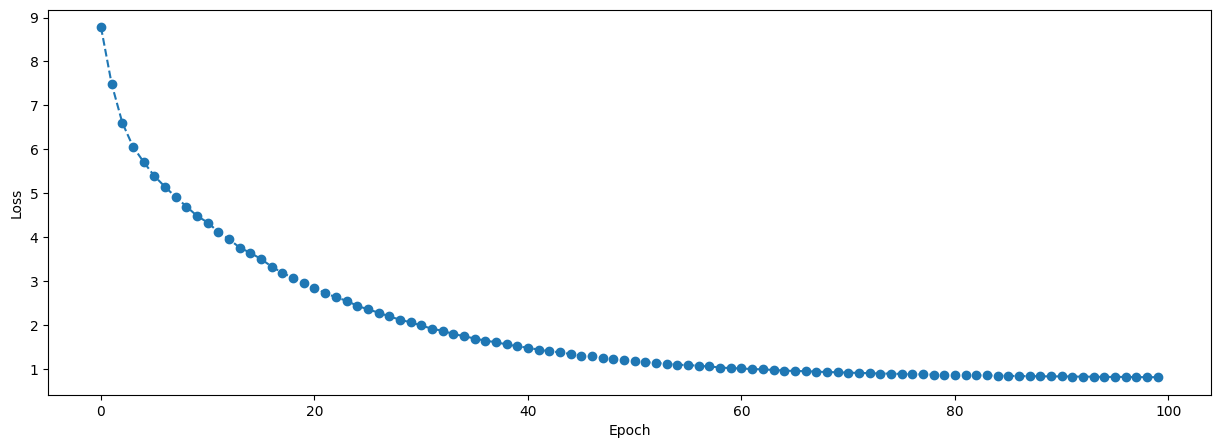

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(range(len(train_losses)), train_losses, linestyle="--", marker="o")
ax.set(xlabel="Epoch", ylabel="Loss")

c:\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Python311\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 

[Text(0.5, 1.0, 'UMAP')]

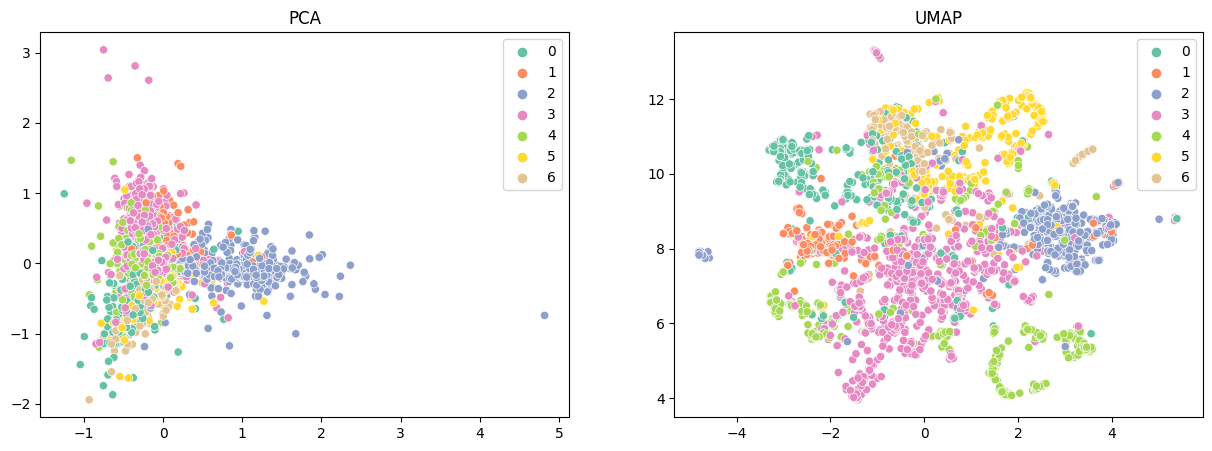

In [8]:
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP

from random_walk_model import get_representations


z = get_representations(deepwalk)

z_PCA = PCA(n_components=2).fit_transform(z)
z_UMAP = UMAP(n_components=2).fit_transform(z)

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.scatterplot(x=z_PCA[:, 0], y=z_PCA[:, 1], hue=data.y, palette="Set2", ax=axs[0])
axs[0].set(title="PCA")
sns.scatterplot(x=z_UMAP[:, 0], y=z_UMAP[:, 1], hue=data.y, palette="Set2", ax=axs[1])
axs[1].set(title="UMAP")

Zaimportujemy funkcje z poprzedniego zeszytu:

In [9]:
%run "2. Zadania w przetwarzaniu grafów.ipynb"

{'train_auc': 0.7510851551438024, 'test_auc': 0.5092691608718829}
{'train_auc': 0.5938125617272384, 'test_auc': 0.5662466610320253}
{'train_auc': 0.9404451884019617, 'test_auc': 0.5264130636614107}


## 3.4. Ewaluacja w zadaniach

**Klasyfikacja węzłów**

In [10]:
nc_metrics = evaluate_node_classification(data=data, z=z)

print("-- Node classification --")
print(f"Train AUC: {nc_metrics['train_auc'] * 100.:.2f} [%]")
print(f"Test AUC: {nc_metrics['test_auc'] * 100.:.2f} [%]")

-- Node classification --
Train AUC: 97.79 [%]
Test AUC: 93.06 [%]


**Predykcja krawędzi**

In [11]:
lp_dataset = prepare_train_test_sets(edge_index=data.edge_index)

lp_deepwalk, _ = train_random_walk_model(
    edge_index=lp_dataset["train_edges_pos"], 
    p=1.0,
    q=1.0,
    num_epochs=100,
)

lp_z = get_representations(lp_deepwalk)

lp_metrics = evaluate_link_prediction(
    train_edges=lp_dataset["train_edges"],
    y_train=lp_dataset["y_train"],
    test_edges=lp_dataset["test_edges"],
    y_test=lp_dataset["y_test"],
    transformation_name="average",
    z=lp_z,
)

print("-- Link prediction --")
print(f"Train AUC: {lp_metrics['train_auc'] * 100.:.2f} [%]")
print(f"Test AUC: {lp_metrics['test_auc'] * 100.:.2f} [%]")

Liczba parametrów modelu: 346,624


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

-- Link prediction --
Train AUC: 69.09 [%]
Test AUC: 64.31 [%]


**Klasyfikacja grafów**

Dla zadania klasyfikacji grafów użyjemy zbioru ENZYMES, w którym każdy graf reprezentuje pojedynczy enzym:

In [12]:
from torch_geometric.datasets import TUDataset
from tqdm.auto import tqdm


enzymes = TUDataset(root="./data", name="ENZYMES")

print(f"Liczba grafów: {len(enzymes)}")

enzymes_subset, _ = train_test_split(
    [e for e in enzymes], 
    train_size=0.1, 
    stratify=[e.y.item() for e in enzymes],
)
print(f"Ograniczymy liczbę grafów do {len(enzymes_subset)}")

z = []

for enzyme in tqdm(enzymes_subset, desc="Embedding graphs"):
    model, _ = train_random_walk_model(
        edge_index=enzyme.edge_index,
        p=1.0,
        q=1.0,
        num_epochs=10,
        quiet=True,
    )
    
    z.append(get_representations(model))
        
        
y = torch.tensor([e.y for e in enzymes_subset])

gc_metrics = evaluate_graph_classification(z, y, transformation_name="average")

print("-- Graph classification --")
print(f"Train AUC: {gc_metrics['train_auc'] * 100.:.2f} [%]")
print(f"Test AUC: {gc_metrics['test_auc'] * 100.:.2f} [%]")

Liczba grafów: 600
Ograniczymy liczbę grafów do 60


Embedding graphs:   0%|          | 0/60 [00:00<?, ?it/s]

-- Graph classification --
Train AUC: 100.00 [%]
Test AUC: 57.24 [%]
